<a href="https://colab.research.google.com/github/T0mLam/Rice-Classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rice Image Classification using CNN

## Import dependencies

#### Install the required modules

In [ ]:
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install sklearn
%pip install seaborn
%pip install opendatasets
%pip install pytorch
%pip install torchvision
%pip install tqdm

#### Import the required modules

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
torch.manual_seed(0)

from tqdm import tqdm

## Preprocessing

#### Download the Rice Image Dataset from Kaggle



Your Kaggle API username and key will be required <br>
To create one: https://www.kaggle.com/settings

In [ ]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset')

#### Create a PyTorch Dataset

In [ ]:
class RiceImageDataset(Dataset):
    def __init__(self, img_dir, transform):
        super().__init__()
        self.img_folder = ImageFolder(
            root=img_dir,
            transform=transform
        )

    def __getitem__(self, index):
        return self.img_folder[index]

    def __len__(self):
        return len(self.img_folder)

Create a composed transform to
1.   resize the images to a RGB image of 64x64 pixels
2.   convert the image into tensor for the input of the CNN



In [ ]:
composed_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
dataset = RiceImageDataset('rice-image-dataset/Rice_Image_Dataset', composed_transform)

PyTorch ImageFolder automatically maps categorical classes into numeric indices

In [ ]:
dataset.img_folder.class_to_idx

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

#### Create the training, validation and testing set

Using PyTorch random_split to split the dataset into training, validation and testing dataset with a proportion of 0.8, 0.1, 0.1 respectively

In [ ]:
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

In [ ]:
print('The shape of each image: ', train_set[0][0].shape)
print('The number of training samples: ', len(train_set))
print('The number of validation samples: ', len(val_set))
print('The number of testing samples: ', len(test_set))

The shape of each image:  torch.Size([3, 64, 64])
The number of training samples:  60000
The number of validation samples:  7500
The number of testing samples:  7500


Images in the dataset can be visualized with the customized show_image function

In [ ]:
def show_image(sample):
    rice_type = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
    plt.imshow(sample[0].permute(1, 2, 0))
    plt.title(f'y = {str(sample[1])} ({rice_type[sample[1]]})')

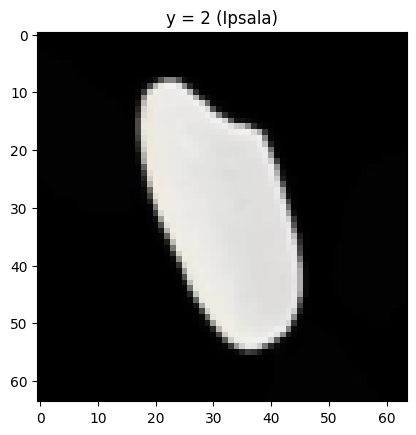

In [ ]:
show_image(test_set[800])

Create a PyTorch DataLoader to load a batch size of 128 images in every iteration

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=128)
test_loader = DataLoader(dataset=test_set, batch_size=128)

## Create the model

#### Create a PyTorch CNN Classifier

In [ ]:
class RiceCNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=64*16*16, out_features=32)
        self.bn3 = nn.BatchNorm1d(num_features=32)

        self.lin2 = nn.Linear(in_features=32, out_features=5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.lin1(x)
        x = self.bn3(x)
        x = torch.relu(x)

        return x

Create an instance of the model and send it to the GPU for execution if available

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model = RiceCNNClassifier()
model.to(device)

RiceCNNClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=16384, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=32, out_features=5, bias=True)
)

Define the hyperparameters, loss function and the optimizer of the model

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Train the model

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS):
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}:')

        cum_loss = correct = 0
        model.train()
        for x, y in tqdm(train_loader, desc='Training', colour='#FFEA00'):
            x, y = x.to(device), y.to(device)
            z = model(x)
            _, y_ = torch.max(z, 1)
            correct += (y_ == y).sum().item()
            loss = criterion(z, y)
            cum_loss += loss.data.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        acc = correct / len(train_set)
        train_acc.append(acc)

        loss = cum_loss / len(train_set)
        train_loss.append(loss)

        print(f'Training Loss = {loss} | Accuracy = {acc}')

        cum_loss = correct = 0
        model.eval()
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc='Validation', colour='#93C572'):
                x, y = x.to(device), y.to(device)
                z = model(x)
                _, y_ = torch.max(z, 1)
                correct += (y_ == y).sum().item()
                loss = criterion(z, y)
                cum_loss += loss.data.item()
            acc = correct / len(val_set)
            val_acc.append(acc)

            loss = cum_loss / len(val_set)
            val_loss.append(loss)

            print(f'Validation Loss = {loss} | Accuracy = {acc}', end='\n\n')

    return train_acc, train_loss, val_acc, val_loss

In [ ]:
train_acc, train_loss, val_acc, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

Epoch 1:


Training: 100%|██████████| 469/469 [01:16<00:00,  6.12it/s]


Training Loss = 0.010666321965058645 | Accuracy = 0.9717666666666667


Validation: 100%|██████████| 59/59 [00:08<00:00,  6.68it/s]


Validation Loss = 0.007142333213488261 | Accuracy = 0.9905333333333334

Epoch 2:


Training: 100%|██████████| 469/469 [01:14<00:00,  6.32it/s]


Training Loss = 0.004929319575925668 | Accuracy = 0.9925166666666667


Validation: 100%|██████████| 59/59 [00:08<00:00,  6.63it/s]


Validation Loss = 0.004162032345930735 | Accuracy = 0.9890666666666666

Epoch 3:


Training: 100%|██████████| 469/469 [01:10<00:00,  6.61it/s]


Training Loss = 0.0026414083652198314 | Accuracy = 0.9937666666666667


Validation: 100%|██████████| 59/59 [00:08<00:00,  7.35it/s]


Validation Loss = 0.0021443933188915252 | Accuracy = 0.9952

Epoch 4:


Training: 100%|██████████| 469/469 [01:10<00:00,  6.70it/s]


Training Loss = 0.0015948542311787605 | Accuracy = 0.9953333333333333


Validation: 100%|██████████| 59/59 [00:08<00:00,  7.08it/s]


Validation Loss = 0.001246940133968989 | Accuracy = 0.9948

Epoch 5:


Training: 100%|██████████| 469/469 [01:09<00:00,  6.72it/s]


Training Loss = 0.0010534375590582688 | Accuracy = 0.99625


Validation: 100%|██████████| 59/59 [00:08<00:00,  6.76it/s]

Validation Loss = 0.0011278708070516586 | Accuracy = 0.996



Plot the accuracy and average loss of every epoch for the training and validation set

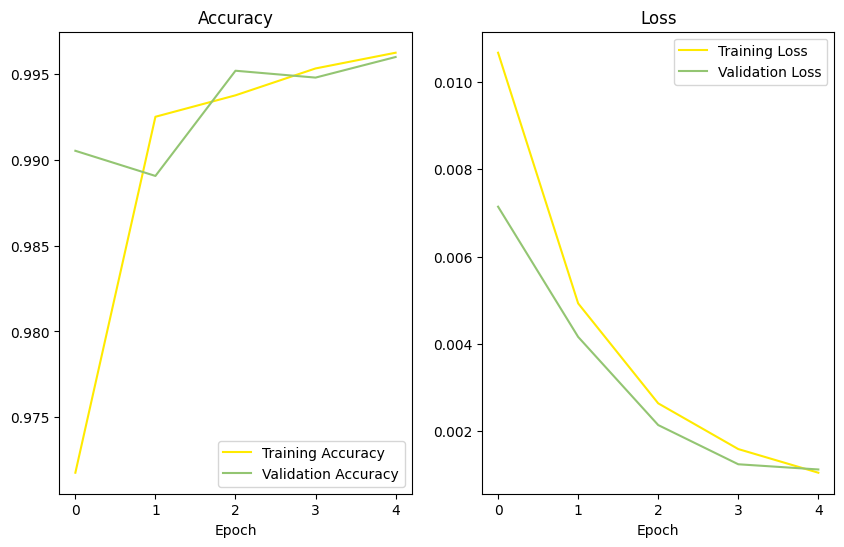

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))


axes[0].plot(train_acc, color='#FFEA00', label='Training Accuracy')
axes[0].plot(val_acc, color='#93C572', label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_title('Accuracy')
axes[0].legend()

axes[1].plot(train_loss, color='#FFEA00', label='Training Loss')
axes[1].plot(val_loss, color='#93C572', label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_title('Loss')
axes[1].legend()

fig.show()

## Evaluate the model

#### Test the model

In [ ]:
def test_model(model, test_loader, criterion, optimizer):
    true_list = []
    pred_list = []
    correct = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(test_loader, desc='Testing', colour='#A020F0'):
            x, y = x.to(device), y.to(device)
            z = model(x)
            _, y_ = torch.max(z, 1)
            true_list.extend(y.cpu().tolist())
            pred_list.extend(y_.cpu().tolist())
            correct += (y_ == y).sum().item()

    acc = correct / len(test_set)
    print(f'\nTest Accuracy = {acc}')
    return acc, true_list , pred_list

In [ ]:
accuracy, y, predictions = test_model(model, test_loader, criterion, optimizer)

Testing: 100%|██████████| 59/59 [00:09<00:00,  6.49it/s]


Test Accuracy = 0.9964


#### Display the results

Plot the testing accuracy along with the previous training and validation results

$$Accuracy=\frac{Correct\,labels}{All\,labels}$$

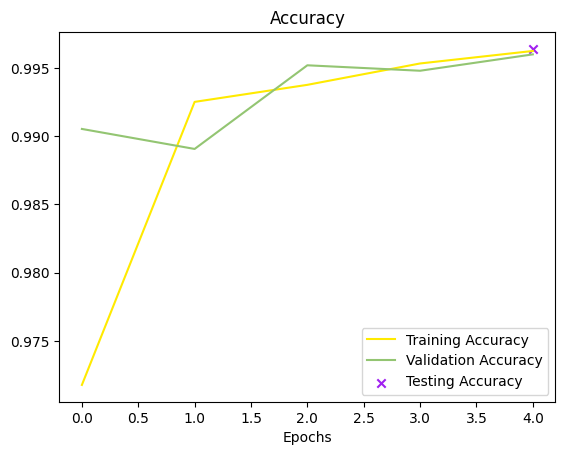

In [ ]:
plt.plot(train_acc, color='#FFEA00', label='Training Accuracy')
plt.plot(val_acc, color='#93C572', label='Validation Accuracy')
plt.scatter(EPOCHS - 1, accuracy, color='#A020F0', label='Testing Accuracy', marker='x')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.legend()
plt.show()

Use sklearn classification_report to display a detailed analysis of the results

Highlights:
$$precision=\frac{TP}{TP+FP}$$ <br>
$$recall=\frac{TP}{TP+FN}$$ <br>
$$\textit{F1}=\frac{2 * precision*recall}{precision+recall}$$

In [ ]:
print(classification_report(
    y,
    predictions,
    digits=4,
    target_names=['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
))

              precision    recall  f1-score   support

     Arborio     0.9979    0.9917    0.9948      1453
     Basmati     0.9980    0.9948    0.9964      1529
      Ipsala     0.9993    1.0000    0.9997      1502
     Jasmine     0.9909    0.9967    0.9938      1528
   Karacadag     0.9960    0.9987    0.9973      1488

    accuracy                         0.9964      7500
   macro avg     0.9964    0.9964    0.9964      7500
weighted avg     0.9964    0.9964    0.9964      7500



Create a confusion matrix using seaborn to visualize the prediction distribution <br>
**x: prediction** <br>
**y: true label**

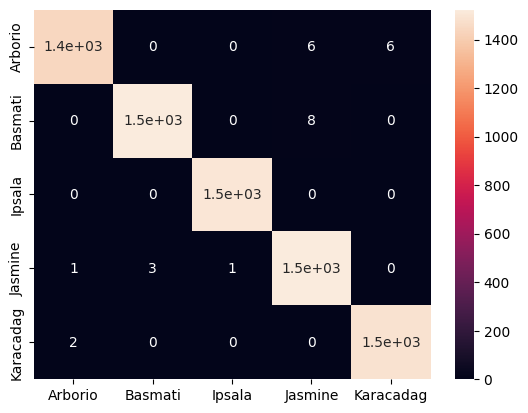

In [ ]:
confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y, predictions),
    columns=['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'],
    index=['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
)
sns.heatmap(confusion_matrix_df, annot=True, xticklabels=True, yticklabels=True)
plt.show()

In [ ]:
def plot_results(correct=True):
    count = 0
    fig, axes = plt.subplots(1, 5, figsize=(10, 8))
    rice_type = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
    for i in range(len(test_set)):
        if count == 5:
            break
        if correct and y[i] == predictions[i]:
            axes[count].imshow(test_set[i][0].permute(1, 2, 0))
            axes[count].set_title(
                f'y = {str(test_set[i][1])} ({rice_type[test_set[i][1]]}) \n Predicted: {rice_type[predictions[i]]}',
                color='green'
            )
            count += 1
        elif not correct and y[i] != predictions[i]:
            axes[count].imshow(test_set[i][0].permute(1, 2, 0))
            axes[count].set_title(
                f'y = {str(test_set[i][1])} ({rice_type[test_set[i][1]]}) \n Predicted: {rice_type[predictions[i]]}',
                color='red'
            )
            count += 1
    fig.tight_layout()
    fig.show()

Show 5 examples of the correctly classified images


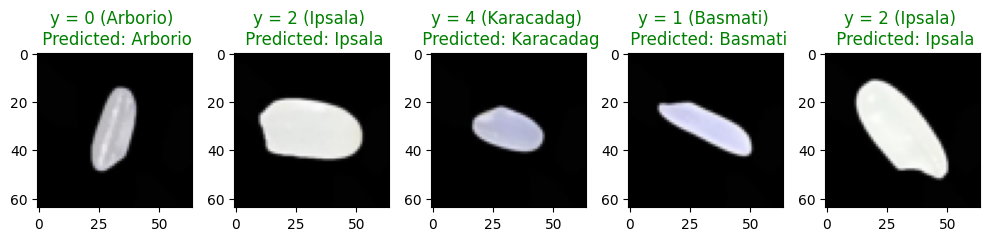

In [ ]:
plot_results(correct=True)

Show 5 examples of the incorrectly classified images

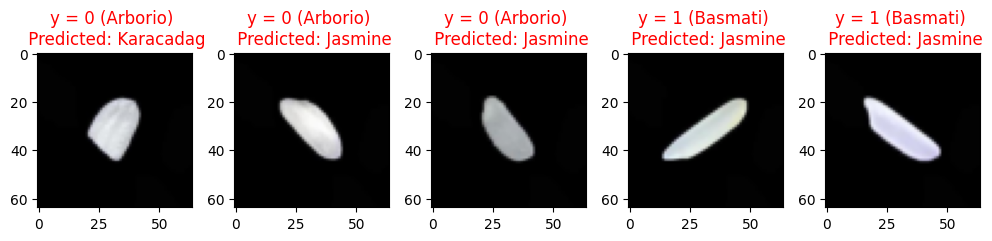

In [ ]:
plot_results(correct=False)